# $T_\mathrm{nw}(k| h, \omega_b, \omega_m):~\mathrm{Savitzky-Golay~Filter}$

## $\mathrm{Data}$

In [1]:
import numpy as np

In [2]:
# Load data
# Assuming the data is structured as {k, h, ωb, ωm, Φ}
data_transfer_function = np.loadtxt("Data/Transfer_Function_h_omegab_omegam.txt", dtype=float)

In [3]:
# Check the length of the data and calculate the number of lists
length_data_transfer_function = len(data_transfer_function)
num_lists = int(length_data_transfer_function / 114)
print("Total number of points: ", length_data_transfer_function,
      "\nNumber of cosmologies: ", num_lists)

Total number of points:  7296 
Number of cosmologies:  64


In [4]:
# Partition the data into lists of 114 elements each
part_data = np.array_split(data_transfer_function, num_lists)

In [5]:
# Normalize data to get T(k)
norm_part_data = []
for i in range(num_lists):
    max_phi = np.max(part_data[i][:, 4])
    norm_part_data.append(np.column_stack((part_data[i][:, 0], part_data[i][:, 1], part_data[i][:, 2], part_data[i][:, 3], part_data[i][:, 4] / max_phi)))

In [6]:
# Extract only the {k, T(k)}
transfer_class = np.array([
    [(norm_part_data[i][j, 0], norm_part_data[i][j, 4]) for j in range(len(norm_part_data[i]))]
    for i in range(len(norm_part_data))
])

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
# Plot properties: font and image size.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 24,# Change to 24 if below items are uncommented
    "figure.figsize": (7, 5),
    "figure.dpi": 80
})

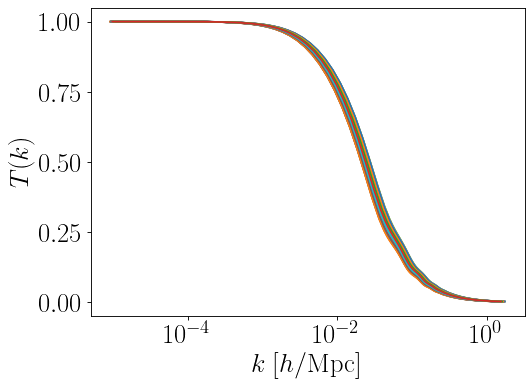

In [9]:
# Plot each list using in Log-space for k
for j in range(len(transfer_class)):
    data = np.array([(transfer_class[j][i, 0], transfer_class[j][i, 1]) for i in range(len(transfer_class[j]))])
    plt.semilogx(data[:, 0], data[:, 1], linestyle='-')

# Set axis titles
plt.xlabel(r"$k \ [h/\mathrm{Mpc}]$")
plt.ylabel(r"$T(k)$")

# Show the plot
plt.show()

In [10]:
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d

In [11]:
# Interpolate the datasets to get more points
# We interpolate in logk-space to get a fair distro of points
Interpolated_data = []
for i in range(len(transfer_class)):
    interpolTk = scipy.interpolate.interp1d(np.log(transfer_class[i][:,0]), np.log(transfer_class[i][:,1]), kind = 'cubic', fill_value='extrapolate')
    k_vals = np.logspace(np.log10(transfer_class[i][0,0]), np.log10(transfer_class[i][-1,0]), 20000)
    Tk_interpolated = np.exp(interpolTk(np.log(k_vals)))
    
    Data_Tk = np.array(list(zip(k_vals, Tk_interpolated)))
    Interpolated_data = np.append(Interpolated_data, Data_Tk, axis = None)
    
Data = Interpolated_data.reshape(int(len(Interpolated_data)/2), 2)

In [25]:
np.savetxt('Data/Interpolated_Tk.txt', Data)

In [26]:
# Partition the data into lists of 114 elements each
InterpolData_Tk = np.array_split(Data, num_lists)

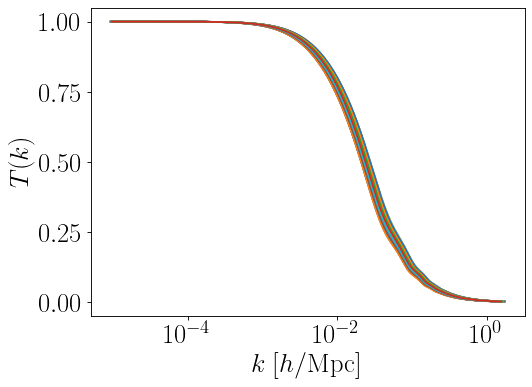

In [27]:
# Plot each list using in Log-space for k
for j in range(len(InterpolData_Tk)):
    data = np.array([(InterpolData_Tk[j][i, 0], InterpolData_Tk[j][i, 1]) for i in range(len(InterpolData_Tk[j]))])
    plt.semilogx(data[:, 0], data[:, 1], linestyle='-')

# Set axis titles
plt.xlabel(r"$k \ [h/\mathrm{Mpc}]$")
plt.ylabel(r"$T(k)$")

# Show the plot
plt.show()

## $\mathrm{Smoothing}$

In [28]:
import os
from scipy.signal import savgol_filter

In [29]:
Store = []
for i in range(len(InterpolData_Tk)):
    k_vals = InterpolData_Tk[i][:,0]
    Tk_vals = InterpolData_Tk[i][:,1]
    k_fx = np.log(np.array(k_vals))
    Tk_fy = np.log(np.array(Tk_vals))

    # interpolate + smooth
    itp = interp1d(k_fx, Tk_fy, kind='cubic')

    # Filter
    Tk_sg = savgol_filter(itp(k_fx), 5001, 3)

    # Organize data
    Data_Tk_k = np.array(list(zip(np.exp(k_fx), np.exp(Tk_sg))))
    Store = np.append(Store, Data_Tk_k, axis = None)
Data_export = Store.reshape(int(len(Store)/2), 2)

In [30]:
np.savetxt('Data/Filtered_Tk.txt', Data_export)

In [31]:
Data_Tk_nw = np.loadtxt('Data/Filtered_Tk.txt')

In [32]:
part_data_Tk = np.array_split(Data_Tk_nw, num_lists)

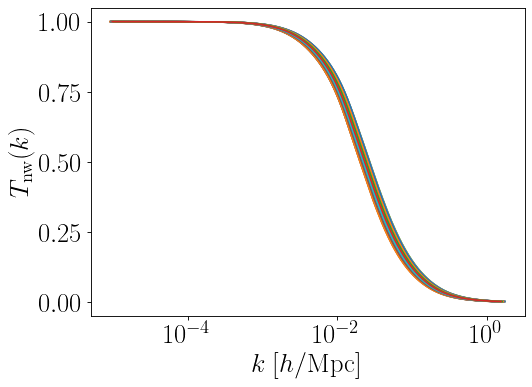

In [33]:
# Plot each list using in Log-space for k
for j in range(len(part_data_Tk)):
    data = np.array([(part_data_Tk[j][i, 0], part_data_Tk[j][i, 1]) for i in range(len(part_data_Tk[j]))])
    plt.semilogx(data[:, 0], data[:, 1], linestyle='-')

# Set axis titles
plt.xlabel(r"$k \ [h/\mathrm{Mpc}]$")
plt.ylabel(r"$T_\mathrm{nw}(k)$")

# Show the plot
plt.show()

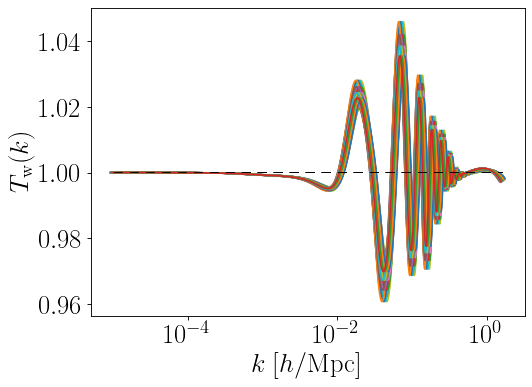

In [34]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each list using ListLogLinearPlot equivalent
for j in range(len(part_data_Tk)):
    data = np.array([(part_data_Tk[j][i, 0], InterpolData_Tk[j][i, 1]/part_data_Tk[j][i, 1]) for i in range(len(part_data_Tk[j]))])
    ax.plot(data[:, 0], data[:, 1], linestyle='-')
    ax.plot(part_data_Tk[0][:,0], np.ones(20000), linestyle = '--', color = 'black', linewidth = 0.8, dashes = (10, 8))

# Set plot properties
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax.set_ylabel(r'$T_\mathrm{w}(k)$')

# Show the plot
plt.show()

# $\mathrm{Test~Data:~} P(k|h, \omega_b, \omega_m, n_s, A_s)$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [4]:
# Load spectra
files = sorted(glob.glob("./Data/spectra_latin_hc/*.txt"))
spectra = [np.loadtxt(f, skiprows=1) for f in files]

In [7]:
# Lista para almacenar resultados
InterpolData_Pk = []
FilteredData_Pk = []
RelativeError = []

for spec in spectra:
    k_original = spec[:, 0]
    Pk_original = spec[:, 1]

    # Interpolation in log-log space
    logk = np.log(k_original)
    logPk = np.log(Pk_original)
    interp_func = interp1d(logk, logPk, kind='cubic', fill_value='extrapolate')

    # Log-grid
    logk_uniform = np.linspace(logk[0], logk[-1], 20000)
    Pk_interp = np.exp(interp_func(logk_uniform))
    k_uniform = np.exp(logk_uniform)

    InterpolData_Pk.append(np.column_stack([k_uniforme, Pk_interp]))

    # Smoothing
    Pk_smooth = savgol_filter(np.log(Pk_interp), 5001, 3)
    Pk_smooth = np.exp(Pk_smooth)
    FilteredData_Pk.append(np.column_stack([k_uniform, Pk_smooth]))

    # Relative error
    error_rel = np.abs((Pk_interp - Pk_smooth) / Pk_interp)*100
    RelativeError.append(error_rel)

In [46]:
# Export the relative errors
Data_export = np.vstack(FilteredData_Pk)
np.savetxt('Data/Filtered_Pk.txt', Data_export)

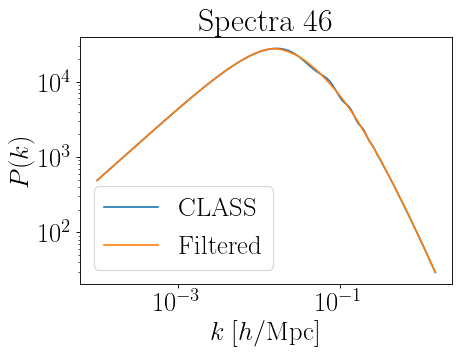

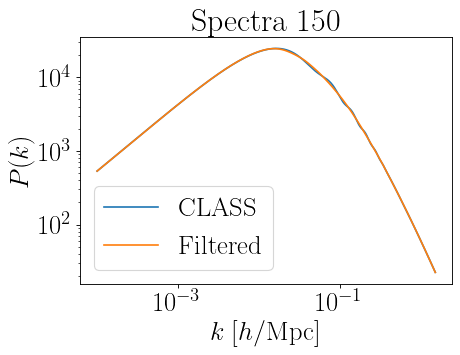

In [47]:
for i in [46, 150]:  
    k = InterpolData_Pk[i][:, 0]
    Pk = InterpolData_Pk[i][:, 1]
    Pk_smooth = FilteredData_Pk[i][:, 1]

    plt.figure(figsize=(6, 4))
    
    plt.loglog(k, Pk, label=r"$\mathrm{CLASS}$")
    plt.loglog(k, Pk_smooth, label=r"$\mathrm{Filtered}$")
    plt.xlabel(r"$k \ [h/\mathrm{Mpc}]$")
    plt.ylabel(r"$P(k)$")
    plt.title(r"$\mathrm{Spectra}~" f"{i}$")
    plt.legend()
plt.show()

In [12]:
mean_errors = [np.mean(err) for err in RelativeError]
np.mean(mean_errors)

1.0471162633652213

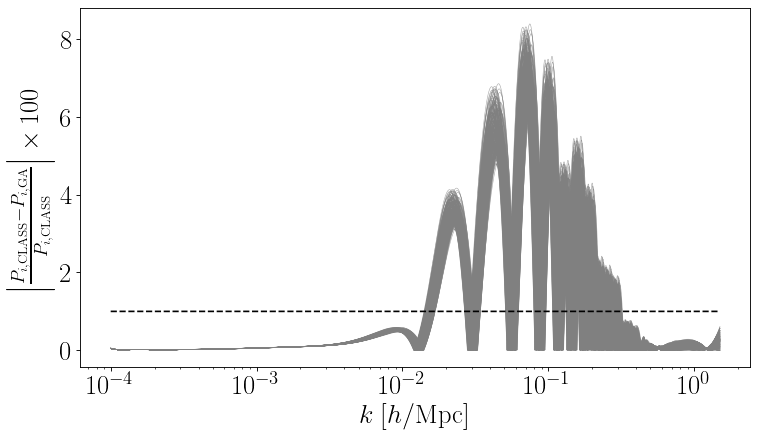

In [37]:
plt.figure(figsize=(10, 6))

for i in range(len(InterpolData_Pk)):
    k = InterpolData_Pk[i][:, 0]
    error_rel = RelativeError[i]
    
    plt.semilogx(k, error_rel, color='gray', linewidth=0.5, alpha=0.7)

plt.semilogx(InterpolData_Pk[0][:, 0], np.ones(len(InterpolData_Pk[0][:, 0])), '--', color='black')

plt.xlabel(r"$k \ [h/\mathrm{Mpc}]$")
plt.ylabel(r"$\left|\frac{P_{i, \mathrm{CLASS}} - P_{i, \mathrm{GA}}}{P_{i, \mathrm{CLASS}}}\right| \times 100$")
plt.tight_layout()
plt.show()
